# The Lasso

The lasso is a shrinkage method like ridge with one major difference: the penalty term. In ridge regression the penalty term is defined as $\lambda\sum_{j=1}^p \beta_j^2$, while in lasso it's defined as $\lambda\sum_{j=1}^p |\beta_j|$. This later penalty makes the solution nonlinear and there is no closed-form solution as in ridge regression.

The lasso solution is a quadratic programming problem. However, as we can see in section 3.4.4, we can use *LARS* with a slight modification to obtain lasso solution.

In this notebook, we try to implement the lasso-modified LARS from scratch, and to do that we need to understand how the original *LARS* algorithm works:

   * Initialization
       * First, we need to standarize all the predictors $\mathbf{X}$ to have a zero mean and unit variance, and set all the initial coefficients to zero $\beta_1 = \beta_2 = \cdots = \beta_p = 0$. The initial residual is $r = y - \bar y$
       * Find the feature $j$ that has the highest absolute correlation with the residue $r$
       $$j = \underset{j}{\text{argmax }} |\mathbf{X}^T r|$$
       * Add $j$ to the active set $A$

   * For every step $k$
       * Move $\beta[A]$ in the least-angle direction of:
       $$\delta_k = \left(\mathbf{X}[A_k]^\top\mathbf{X}[A_k]\right)^{-1}\mathbf{X}[A_k]^\top r$$
       
       until some other feature $\mathbf{X}_i$ has as much correlation with the $k$ residual as does $\mathbf{X}[A]$ ($\star$).
       
       The coefficient profile evolves as:
       $$\beta[A_k](\alpha) = \beta[A_k] + \alpha \delta_k, 0\leq\alpha\leq 1$$

       The only unknown in these two equations is the $\alpha$. 
       
       It is actually possible to iterate through all possible values of alpha and find one that satisfy the above condition ($\star$). However, there is a more efficient way to find the $\alpha$: LAR look-ahead (Exercise 3.25). In this method, we compute $\alpha$ for features not in the active set $b$, and select the feature that produces minimum angle (largest correlation) with the residue. For features not in the active set, $\alpha$ can be computed as follows:
       
       $$\begin{aligned}
       \alpha^{-} &= \frac{x_b^\top r_k-x_a^\top r_k}{x^\top_b X[A_k]\delta_k - x^\top_a X[A_k]\delta_k}, \text{  or}\\
       \alpha^{+} &= \frac{x_b^\top r_k+x_a^\top r_k}{x^\top_b X[A_k]\delta_k + x^\top_a X[A_k]\delta_k}
       \end{aligned}$$
       
       The next variable that will be added to the active set $A_k$ is $b$ with the minimum $\alpha$.
       
The LAR algorithm with a minor modification results in an efficient way for computing the Lasso coefficient profiles. This modification is done by considering other candidates for $\alpha$ that correspond to values of $\alpha$ such that $\beta[A_k] + \alpha \delta_k=0$:

$$\alpha^{0} = -\beta[A_k] / \delta_j[A_k]$$

From this we know that the $\alpha$ is selected as the $\min(\alpha^{-}, \alpha^{+}, \alpha^{0})$. If the minimum occurs at $\alpha^{0}$, then feature that corresponds to this $\alpha$ is removed from the active set $A$.

### Python Implementation

We use *Prostate Cancer* data to test our implementation of LAR-modified Lasso algorithm. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sys
import scipy.stats
from matplotlib.ticker import FormatStrFormatter
from ml_datasets.esl import ProstateCancer
from esl.utils import scale
from esl.chapter03 import kfold

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

x_train = scale(df_x[train_test=='T'].copy()).values
y_train_temp =  df_y[train_test=='T'].copy().values
y_train = y_train_temp - np.mean(y_train_temp)

Next, we build the `Lasso` class based on the modification of LAR.

This class contains one method:

   * `fit`: to fit the model using the SVD-based ridge regression algorithm. Here, we'll obtain $\hat\beta_{ridge}$.

The following is the complete `Lasso` class:

In [4]:
class Lasso:
    def fit(self, X, y):
        n, p = X.shape
        beta = np.zeros(p)

        r = y.copy()
        corr = X.T @ r
        best_feat = np.argmax(np.abs(corr))
        A = [best_feat]
        beta_path = np.zeros((p, 1))

        while True: 
            d = np.zeros(p)
            d[A] = np.linalg.inv(X[:, A].T @ X[:, A]) @ X[:, A].T @ r
            alpha = 1.0
            for j in range(p):
                if j not in A and beta[j] == 0:
                    alpha_temp = dict()
                    alpha_temp['+'] = (corr[j]  - corr[best_feat]) / (X[:, j].T @ X[:, A] @ d[A] - X[:, best_feat].T @ X[:, A] @ d[A])
                    alpha_temp['-'] = (corr[j]  + corr[best_feat]) / (X[:, j].T @ X[:, A] @ d[A] + X[:, best_feat].T @ X[:, A] @ d[A])

                    for key in alpha_temp.keys():
                        if alpha_temp[key] <= 0.0:
                            alpha_temp[key] = np.inf

                        if alpha_temp[key] <= alpha:
                            alpha = alpha_temp[key]
                            best_feat_temp = j

                elif beta[j] != 0 and j in A:
                    if d[j] != 0:
                        alpha_temp = -beta[j] / d[j]
                        if alpha_temp <= alpha and alpha_temp >= 0.0:
                            alpha = alpha_temp
                            best_feat_temp = -j

            beta = beta + alpha * d  
            beta_path = np.concatenate((beta_path, beta.reshape(-1, 1)), axis=1)

            if alpha == 1.0:
                break

            if best_feat_temp < 0:
                A = [k for k in A if k != np.abs(best_feat_temp)]
                best_feat = A[0]

            else:
                A.append(best_feat_temp)
                best_feat = best_feat_temp

            r = r - alpha * (X @ d)
            corr = X.T @ r
            
        return A, beta_path

In [5]:
lasso = Lasso()
A, beta_path = lasso.fit(x_train, y_train)

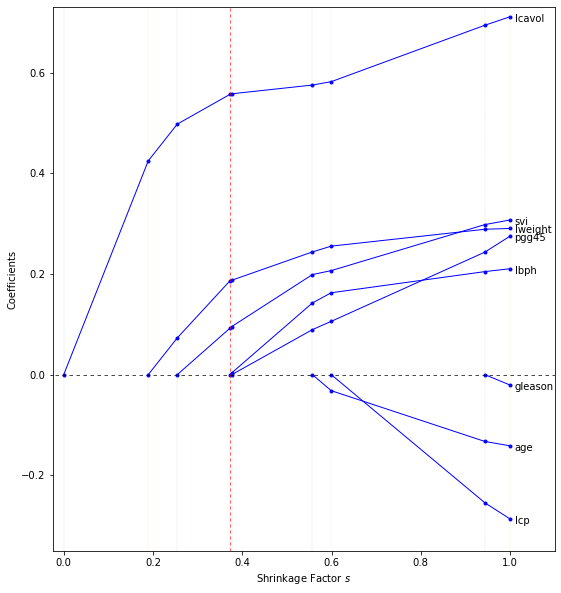

In [13]:
s = np.sum(np.abs(beta_path.T), axis=1)
s /= s[-1]
column_names = prostate_cancer.meta[:-1]
plt.figure(figsize=(9, 10))
plt.xlim([-0.025, 1.1])
plt.ylim([-0.35, 0.73])
yy = np.linspace(-0.35, 0.73)
xx = np.linspace(-0.3, 9.5, len(s))

for i in range(x_train.shape[1]):
    idx_nonzero = np.where(beta_path[i, :] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path[i, idx_nonzero]
    s_temp = s[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'b-o', linewidth=1.0, markersize=3)
    plt.annotate(column_names[i], xy=(1.01, beta_path_temp[-1] - 0.01))
    
for s_ in s:
    plt.plot(s_ * np.ones(len(yy)), yy, ':', linewidth=0.2)
    
plt.plot(xx, np.zeros_like(xx), color='black', linestyle=(0, (5, 5)), linewidth=0.7)
plt.plot(0.37237044 * np.ones(len(yy)), yy, color='red', linestyle=(0, (5, 5)), linewidth=0.6)
plt.xlabel('Shrinkage Factor $s$')
plt.ylabel('Coefficients')
plt.show()